In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from flowprintOptimal.sekigo.core.flowConfig import FlowConfig
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from flowprintOptimal.sekigo.flowUtils.commons import loadFlows, saveFlows
from flowprintOptimal.sekigo.flowUtils.sampler import FixedLengthSampler, FixedLengthSimpleSampler
from flowprintOptimal.sekigo.core.flowRepresentation import FlowRepresentation
from typing import List
from flowprintOptimal.sekigo.flowUtils.flowDatasets import MaxNormalizedDataset,ActivityDataset,BaseFlowDataset,DDQNActivityDataset
from flowprintOptimal.sekigo.dataAnalysis.vNATDataFrameProcessor import VNATDataFrameProcessor
from flowprintOptimal.sekigo.flowUtils.commons import getValidInvalidStartingPointsForSubFlowStart, getActivityArrayFromFlow
from flowprintOptimal.sekigo.modeling.neuralNetworks import LSTMNetwork,TransformerGenerator,CNNNetwork1D
from flowprintOptimal.sekigo.modeling.loggers import Logger
from sklearn.ensemble import RandomForestClassifier
from torch.utils.data import Dataset, DataLoader,WeightedRandomSampler
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt
from joblib import delayed, Parallel
from typing import List
from flowprintOptimal.sekigo.earlyClassification.DQL.memoryFiller import MemoryFiller
from flowprintOptimal.sekigo.earlyClassification.DQL.core import MemoryElement,Rewarder,State
from flowprintOptimal.sekigo.earlyClassification.DQL.datasets import MemoryDataset
from torch.nn.utils.rnn import pack_sequence, unpack_sequence
from flowprintOptimal.sekigo.dataAnalysis.dataFrameProcessor import SoftwareUpdateDataProcessor,GamingDownloadDataFrameProcessor
from flowprintOptimal.sekigo.dataAnalysis.dataFrameExtractor import DataFrameExtractor
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay
from flowprintOptimal.sekigo.earlyClassification.DQL.trainers import EarlyClassificationtrainer
from flowprintOptimal.sekigo.modeling.neuralNetworks import LinearPredictor
import warnings
from flowprintOptimal.sekigo.utils.commons import augmentData
warnings.filterwarnings('ignore')
import torch.nn.functional as F
import random

In [3]:
seq_len = 30
data_dim = 4
random_dim = 128


decoder = TransformerGenerator(random_dim= random_dim,seq_len= seq_len,embedding_dim= 64,num_heads= 4,cond_dim= None,
                               num_layers= 6,output_dim= data_dim,out_layer= nn.Sigmoid()).to(device)
encoder = CNNNetwork1D(in_channels= data_dim,num_filters= 32,output_dim= random_dim,num_layers= 3,num_outputs= 2,cond_dim= None).to(device)

encoder = torch.compile(encoder)
decoder = torch.compile(decoder)
encoder.load_state_dict(torch.load("models/VAE/encoder.pt"))
decoder.load_state_dict(torch.load("models/VAE/decoder.pt"))

encoder = encoder.eval()
decoder = decoder.eval()

In [3]:
flow_config = FlowConfig(grain= 1, band_thresholds= [1250])
processor1 = SoftwareUpdateDataProcessor(parquet_path= "data/software-update-1w.parquet")
processor2 = GamingDownloadDataFrameProcessor(parquet_path= "data/2023-12-01--2023-12-31--flowprint.parquet")
flows = DataFrameExtractor.getData(data_frame_processors= [processor2,processor1],needed_flow_config= flow_config)
class_type_filtered_flows = flows
FT_filtered_flows = list(filter(lambda x : x.class_type != "Download",class_type_filtered_flows))
FT_flows = list(filter(lambda x : x.class_type == "Download",class_type_filtered_flows))
len(FT_filtered_flows) + len(FT_flows) == len(class_type_filtered_flows)

initial software update length = 72826
final software update length = 36790
after adding uploads size = 73580


True

In [23]:
flows = loadFlows(path= "data/VNAT/flowStore/vnatflowshalfsecond_2_bands.json")
class_type_filtered_flows = VNATDataFrameProcessor.convertLabelsToTopLevel(flows)
FT_filtered_flows = list(filter(lambda x : x.class_type != "FT",class_type_filtered_flows))
FT_flows = list(filter(lambda x : x.class_type == "FT",class_type_filtered_flows))
len(FT_filtered_flows) + len(FT_flows) == len(class_type_filtered_flows)

True

In [32]:
class_type_filtered_flows[4000].up_bytes.shape

(2, 1)

In [27]:
length_filtered = list(filter(lambda x : x.up_bytes.shape[1] > 20, class_type_filtered_flows))

In [28]:
pd.Series(map(lambda x : x.class_type, length_filtered)).value_counts()

control      1637
streaming     840
FT            667
chat          563
Name: count, dtype: int64

In [34]:
sampler = FixedLengthSampler(flow_config= FT_filtered_flows[0].flow_config,required_length_in_seconds = 30,ratio_of_median_to_sample= .1,min_activity_for_start_point= 25,sample_wise_train_ratio= .8, temporal_train_ratio= 1)
FT_filtered_split_flows = sampler.sampleAndCutToLength(data= FT_filtered_flows)
ft_sampler = FixedLengthSampler(flow_config= FT_filtered_flows[0].flow_config,required_length_in_seconds = 30,ratio_of_median_to_sample= .5,min_activity_for_start_point= 25,sample_wise_train_ratio= 1, temporal_train_ratio= 1)
FT_split_flows = ft_sampler.sampleAndCutToLength(data= FT_flows)
all_sampler = FixedLengthSampler(flow_config= class_type_filtered_flows[0].flow_config,required_length_in_seconds = 30,ratio_of_median_to_sample= .1,min_activity_for_start_point= 25,sample_wise_train_ratio= .8, temporal_train_ratio= 1)
all_flows = all_sampler.sampleAndCutToLength(data= class_type_filtered_flows)

{'chat': 0.009978081619872665, 'control': 0.17486738613499178, 'streaming': 0.0999790838736666}
overlapping points = 0
{'FT': 0.49921752738654146}
overlapping points = 0
{'FT': 1, 'chat': 0.05498904080993633, 'control': 0.9636912383391256, 'streaming': 0.55098305793767}
overlapping points = 0


In [36]:
print(pd.Series(map(lambda x : x.class_type,FT_filtered_split_flows["train_flows"])).value_counts())
print(pd.Series(map(lambda x : x.class_type,FT_filtered_split_flows["test_flows"])).value_counts())
print(pd.Series(map(lambda x : x.class_type,all_flows["train_flows"])).value_counts())
print(pd.Series(map(lambda x : x.class_type,all_flows["test_flows"])).value_counts())
print(pd.Series(map(lambda x : x.class_type,FT_split_flows["train_flows"])).value_counts())
#print(pd.Series(map(lambda x : x.class_type,FT_split_flows["test_flows"])).value_counts())

control      1929
streaming    1720
chat         1400
Name: count, dtype: int64
chat         569
streaming    487
control      206
Name: count, dtype: int64
chat         9415
streaming    9244
control      8198
FT            624
Name: count, dtype: int64
control      2458
streaming    1504
chat         1192
FT             15
Name: count, dtype: int64
FT    325
Name: count, dtype: int64


In [25]:
class DDQNActivityDataset(BaseFlowDataset):
    def __init__(self, flows: List[FlowRepresentation], label_to_index: dict,do_aug = False,balance = False):
        super().__init__(flows = flows, label_to_index= label_to_index)
        self.do_aug = do_aug
        self.labels = list(map(lambda x : self.label_to_index[x.class_type],self.flows))
        self.flows = list(map(lambda x : getActivityArrayFromFlow(x), self.flows))

        if balance == True:
            print("balancing")
            self.cureImbalance()
    
    def __getitem__(self, index):
        return dict(data = self.flows[index] if (self.do_aug == False) else augmentData(self.flows[index],fraction_range= [0,.15]), label  = self.labels[index])
    
    def cureImbalance(self):
        
        label_to_indices = dict()
        for i,label in enumerate(self.labels):
            if label not in label_to_indices:
                label_to_indices[label] = []
            label_to_indices[label].append(i)
        
        
        counts = [len(x) for _,x in label_to_indices.items()]
        max_counts = max(counts)
        print(counts)
        added_flows,added_labels = [],[]
        for label,indices in label_to_indices.items():
            to_add = max_counts - len(indices)
            if to_add > 0:
                replication_indices = random.choices(population= indices,k= to_add)
            
                for replication_index in replication_indices:
                    added_flows.append(self.flows[replication_index].copy())
                    added_labels.append(self.labels[replication_index])
        


        self.flows.extend(added_flows)
        self.labels.extend(added_labels)
            

In [26]:
all_train_dataset = DDQNActivityDataset(flows= all_flows["train_flows"],label_to_index= None,do_aug= False,balance= False)
all_test_dataset = DDQNActivityDataset(flows = all_flows["test_flows"], label_to_index= all_train_dataset.label_to_index)
train_dataset = DDQNActivityDataset(flows= FT_filtered_split_flows["train_flows"],label_to_index= None,do_aug= False)
test_dataset = DDQNActivityDataset(flows= FT_filtered_split_flows["test_flows"],label_to_index= train_dataset.label_to_index)
ood_dataset = DDQNActivityDataset(flows= FT_split_flows["train_flows"],label_to_index= None)
#ood_support_dataset = DDQNActivityDataset(flows= FT_split_flows["train_flows"],label_to_index= ood_dataset.label_to_index)

In [78]:
pd.Series(map(lambda x : x["label"],all_train_dataset)).value_counts()

0    869
1    869
2    869
3    869
Name: count, dtype: int64

[[0.04664886 0.04649501 0.04668455 0.04668231 0.04660827 0.04662975
  0.04668901 0.04659536 0.04662084 0.04694938 0.04580732 0.04672945
  0.04237838 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.12088888
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.20760839 0.0416     0.0416     0.0416     0.0416     0.0416
  0.13291034 0.0416     0.0416     0.0416     0.0416     0.08402424
  0.04159996 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.08610908
  0.         0.         0.         0.         0.         0.        ]
 [0.91866667 0.91866667 0.918

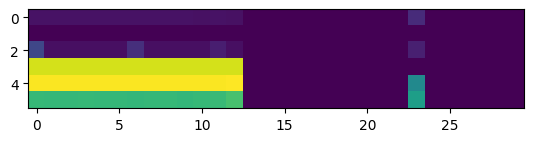

In [53]:
index = np.random.randint(0,len(ood_dataset))
plt.imshow(ood_dataset[index]["data"].T)
print(ood_dataset[index]["data"].T)


{'chat': 0, 'control': 1, 'streaming': 2}
[[0.16986666 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.91866621 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.20456986 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.91866621 0.         0.     

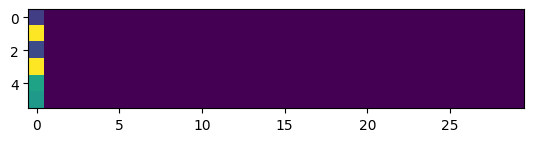

In [26]:
print(train_dataset.label_to_index)
index = np.random.randint(0,len(train_dataset))
plt.imshow(train_dataset[index]["data"].T)
print(train_dataset[index]["data"].T)
print(train_dataset[index]["label"])

In [27]:
class Rewarder:
    def __init__(self,max_length,l,num_labels : int):
        self.max_length = max_length
        self.l = l # l is smaller than 1
        self.num_labels = num_labels

    def reward(self,state : State,action : int):
        if state.label == action:
            # reward 1 on a correct prediction
            return 1, True
        else:
            # either incorrect or wait
            # wait 
            # treat the wait action with a negative reward
            if action == self.num_labels:
                if state.label == -1:
                    # sample is ood then give 0 reward not negative 1
                    if state.length == self.max_length:
                        # if is the last timestamp
                        return self.l*(state.length/self.max_length),True
                    else:
                        return self.l*(state.length/self.max_length),False
                else:
                    # the sample is not ood
                    if state.length == self.max_length:
                        # it is the last timestamp
                        return -self.l*(state.length/self.max_length),True
                    else:
                        # waiting negative reward on ID sample
                        return -self.l*(state.length/self.max_length), False
            else:
                # incorrect
                return -1,True
            


class Rewarder:
    def __init__(self,max_length,l,num_labels : int):
        self.max_length = max_length
        self.l = l # l is smaller than 1
        self.num_labels = num_labels

    def reward(self,state : State,action : int):
        if state.label == action:
            # reward 1 on a correct prediction
            return 1, True
        else:
            # either incorrect or wait
            # wait 
            # treat the wait action with a negative reward
            if action == self.num_labels:
                if state.length == self.max_length:
                    # it is the last timestamp
                    if state.label == -1:
                        assert False
                        return 0, True
                    else:
                        return -1,True#self.l*(state.length/self.max_length),True
                else:
                    if state.label == -1:
                        assert False
                        return 0, False
                    else:
                        return -self.l*(state.length/self.max_length), False
            else:
                # incorrect
                return -1,True

In [16]:
def getOffSample(data,encoder,decoder):
    """
    data is of shape (BS,seq_len,data_dim), pytorch tensor
    """
    encoder.eval()
    decoder.eval()
    def sampleOODZ(mu,log_var,delta):
        sigma = torch.exp(log_var/2)
        epsilon = torch.randn_like(sigma)
        if np.random.random() <= .5:
            z = mu + sigma*delta + sigma*epsilon
        else:
            z = mu - sigma*delta + sigma*epsilon
        return z
    with torch.no_grad():
        mu,log_var = encoder(data,None)
        mu = torch.zeros_like(mu)
        log_var = torch.zeros_like(log_var)
        z_ood = sampleOODZ(mu= mu, log_var= log_var,delta= 1 + np.random.random())
        out_ood = decoder(z_ood,None)[0]
        return out_ood

In [28]:
class MemoryFiller:
    def __init__(self,dataset : BaseFlowDataset,rewarder : Rewarder,min_length_in_seconds : int,max_length_in_seconds,random_sample_ratio : int):
        self.dataset = dataset
        self.rewarder = rewarder

        grain = self.dataset.flow_config.grain
        self.min_length = int(min_length_in_seconds/grain)
        self.max_length = int(max_length_in_seconds/grain)

        self.actions = list(self.dataset.label_to_index.values())  
        self.random_sample_ratio = random_sample_ratio
        self.actions.append(len(self.actions))

    def processSingleSample(self,data):
        flow, label = data["data"], data["label"]
        memory_elements : List[MemoryElement] = []
        for length in range(self.min_length, self.max_length+1):
            for action in self.actions:
                state = State(timeseries= flow,label= label,length= length)
                reward, terminate = self.rewarder.reward(state= state,action= action)
                
                next_state = State(timeseries= flow,label= label,length= length + 1)
                if terminate == True:
                    # I am reducing the length as I will ahve to pass the state to LSTM 
                    # So I instead of filtering I will just zero all terminal states later.
                    next_state.length -= 1
                    next_state.setTerminal()

                
                memory_element = MemoryElement(state= state,action= action,reward= reward,next_state= next_state)
                memory_elements.append(memory_element)
        return memory_elements
    def processDataset(self):

        memory_elements = []
        
        for i in range(1,len(self.dataset)+1):
            # using 1 to len(dataset) + 1 so modulo does not throw an error
            if i%self.random_sample_ratio == 0:
                #data = ood_support_dataset[np.random.randint(len(ood_support_dataset))]
                #data["label"] = -1
                #memory_elements.extend(self.processSingleSample(data))
                """
                #if np.random.random() > .5:
                random_data_value = augmentData(original_data= self.dataset[i-1]["data"],fraction_range= [.2,.8])#np.random.random(self.dataset[i-1]["data"].shape)
                random_data_label = -1
                data = dict(data = random_data_value,label = random_data_label)
                memory_elements.extend(self.processSingleSample(data))
     
                X = torch.tensor(self.dataset[i-1]["data"]).unsqueeze(0).float().to(device)
                X_off = getOffSample(data= X,encoder= encoder,decoder= decoder)[0].cpu().numpy()
                vae_data = dict(data = X_off, label = -1)
                memory_elements.extend(self.processSingleSample(vae_data))
                """
                pass
                

            data = self.dataset[i-1]
            memory_elements.extend(self.processSingleSample(data))
 
        return memory_elements

In [29]:
rewarder = Rewarder(max_length= 30,l= .1,num_labels= len(all_train_dataset.label_to_index))
memory_filler = MemoryFiller(dataset= all_train_dataset,rewarder= rewarder, min_length_in_seconds= 5, max_length_in_seconds= 30,random_sample_ratio= 20)

In [30]:
memory = memory_filler.processDataset()
print(len(memory))

3329560


In [31]:
memory_dataset = MemoryDataset(memories= memory,num_classes= len(all_train_dataset.label_to_index), corrupt_prob= 0,
                               min_length= memory_filler.min_length,max_length= memory_filler.max_length)
predictor = LSTMNetwork(lstm_input_size= 6,lstm_hidden_size= 128,output_dim= len(all_train_dataset.label_to_index) + 1)
logger = Logger(verbose= True)
logger.default_step_size = 1000

In [32]:
ddq_model = EarlyClassificationtrainer(predictor= predictor,train_dataset = all_train_dataset,test_dataset= all_test_dataset,memory_dataset= memory_dataset,
                                       ood_dataset= ood_dataset,
                                       logger= logger,device=device,model_replacement_steps= 100)

In [33]:
ddq_model.train(epochs= 10,batch_size= 128,model_lag_in_steps= 100,lr= .0005) 

 ---- 1000 metric loss = 0.26391721753031017
 ---- 1 metric test_eval_f1 = 0.9258312020460358
 ---- 1 metric test_eval_time = 9.008951406649617
 ---- 1 metric ood_eval = 1.0
 ---- 1 metric ood_eval_time = 30.0
 ---- 2000 metric loss = 0.13307612888328732
 ---- 2 metric test_eval_f1 = 0.9376243250923558
 ---- 2 metric test_eval_time = 9.321113952827508
 ---- 2 metric ood_eval = 1.0
 ---- 2 metric ood_eval_time = 30.0
 ---- 1 metric train_eval_f1 = 0.9491254099640793
 ---- 1 metric train_eval_time = 9.43549898485085
 ---- 3000 metric loss = 0.11292457897402346
 ---- 3 metric test_eval_f1 = 0.9423131571469168
 ---- 3 metric test_eval_time = 9.540920716112533
 ---- 3 metric ood_eval = 0.8646153846153846
 ---- 3 metric ood_eval_time = 28.31692307692308
 ---- 4000 metric loss = 0.1013836984373629
 ---- 4 metric test_eval_f1 = 0.9457232168229611
 ---- 4 metric test_eval_time = 9.901392441034385
 ---- 4 metric ood_eval = 0.36923076923076925
 ---- 4 metric ood_eval_time = 22.252307692307692
 --

KeyboardInterrupt: 

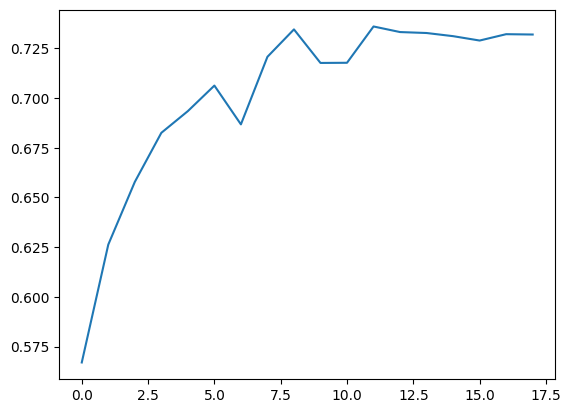

In [51]:
plt.plot(logger.getMetric("train_eval_f1"))

In [19]:
def getPredScores(dataset,model : LSTMNetwork):
    loader = DataLoader(dataset,batch_size = 32)
    model.eval()
    outs = []
    labels = []
    with torch.no_grad():
        for batch in loader:
            X = torch.tensor(batch["data"]).float().to(device)
            labels.extend(batch["label"].numpy().tolist())
            model_out = F.softmax(model.earlyClassificationForward(X= X)[0],dim= -1).cpu().numpy().tolist()
            outs.extend(model_out)
    return np.array(outs),np.array(labels)



In [71]:
outs,labels = getPredScores(dataset= ood_dataset,model= predictor)
outs = outs[:,5:,:]

In [72]:
diff = np.max(a= outs[:,:,:-1],axis= -1) - outs[:,:,-1]

In [29]:
all_train_dataset.label_to_index

{'FT': 0, 'chat': 1, 'control': 2, 'streaming': 3}

In [68]:
res = np.array(ddq_model.predictOnDataset(dataset= all_test_dataset))

In [69]:
ddq_model.eval(all_test_dataset)

(0.7114232692700238, 11.020682523267839)

In [70]:
all_train_dataset.label_to_index

{'FT': 0, 'chat': 1, 'control': 2, 'streaming': 3}

In [71]:
labels = list(map(lambda x : x["label"], all_test_dataset))

In [72]:
pd.Series(labels).value_counts()

0    368
3    277
2    175
1    147
Name: count, dtype: int64

In [73]:
precision_recall_fscore_support(labels,res[:,0].tolist(),zero_division= 0)

(array([0.        , 0.98828125, 0.96052632, 0.95      , 0.7107438 ]),
 array([0.        , 0.6875    , 0.99319728, 0.97714286, 0.93140794]),
 array([0.        , 0.81089744, 0.97658863, 0.96338028, 0.80625   ]),
 array([  0, 368, 147, 175, 277]))

In [18]:
res = np.array(res)

(res[:,0] == -1).sum()/ res.shape[0]

0.3562971390047613

In [16]:
plt.plot(diff[np.random.randint(len(diff))])

NameError: name 'diff' is not defined

In [48]:
ood_preds = ddq_model.predictOnDataset(dataset= ood_dataset)

ood_times = np.array(list(map(lambda x : x[1],ood_preds)))
ood_preds = np.array(list(map(lambda x : x[0],ood_preds)))

In [50]:
pd.Series(ood_times).describe()

count    17553.000000
mean        19.254771
std          8.714918
min          6.000000
25%         11.000000
50%         20.000000
75%         29.000000
max         30.000000
dtype: float64

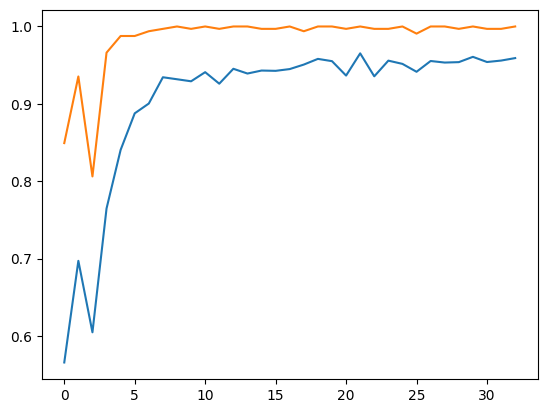

In [26]:
plt.plot(logger.getMetric("test_eval_f1"))
plt.plot(logger.getMetric("ood_eval"))

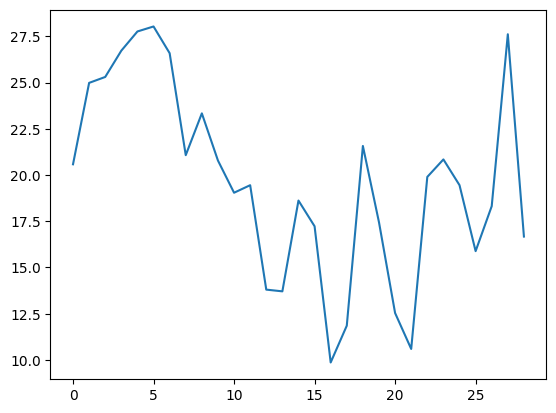

In [14]:
plt.plot(logger.getMetric("test_eval_time"))

In [15]:
ddq_model.evalTrain()

 ---- 15 metric train_eval_f1 = 0.9988468193166163
 ---- 15 metric train_eval_time = 21.4554889298893


In [16]:
ddq_model.evalTest()

 ---- 30 metric test_eval_f1 = 0.9832999473590501
 ---- 30 metric test_eval_time = 21.248101265822786


In [78]:
test_loader = DataLoader(dataset= test_dataset,batch_size= 64,shuffle= False)

In [79]:
def getPrediction(preds,num_classes):
    for p in preds:
        if p < num_classes:
            return p
    return -1

def getPredictionTail(preds,num_classes):
    for p in reversed(preds):
        if p < num_classes:
            return p
    return -1

def predictionConsistency(pred : list,num_classes):
    is_predicted = None
    is_consistent = True
    for i,p in enumerate(pred):
        if p < num_classes:
            if is_predicted == None:
                is_predicted = (i+1,p)
            elif is_predicted[1] == p:
                continue
            else:
                is_consistent = False
                break
        
    return is_consistent


def strongPredictionConsistency(pred : list,num_classes):
    is_predicted = None
    is_consistent = True
    for i,p in enumerate(pred):
        if is_predicted == None:
            if p < num_classes:
                is_predicted = p
        else:
            if p != is_predicted:
                is_consistent = False
                break
        
    return is_consistent

def awarenessCheck(batch_preds : list,labels : list):
    is_aware = []
    for i in range(len(batch_preds)):
        if labels[i] in batch_preds[i]:
            is_aware.append(True)
        else:
            is_aware.append(False)

    return is_aware

In [ ]:
preds = []
tail_preds = []
labels = []
consistencies = []
awareness = []
original_preds = []

for batch in test_loader:
    batch_preds = ddq_model.predictStep(batch["flow"].float()).numpy().tolist()
    batch_labels = batch["label"].numpy().tolist()
    original_preds.extend(batch_preds)
    preds.extend(list(map(lambda x : getPrediction(x,len(test_dataset.label_to_index)),batch_preds)))
    tail_preds.extend(list(map(lambda x : getPredictionTail(x,len(test_dataset.label_to_index)),batch_preds)))
    labels.extend(batch_labels)
    awareness.extend(awarenessCheck(batch_preds= batch_preds,labels= batch_labels))

    consistencies.extend(list(map(lambda x : strongPredictionConsistency(x,len(test_dataset.label_to_index)),batch_preds)))

In [ ]:
preds = np.array(preds)
tail_preds = np.array(tail_preds)
labels = np.array(labels)
consistencies = np.array(consistencies)
awareness = np.array(awareness)

In [ ]:
awareness.sum()/awareness.shape

array([0.98450057])

In [ ]:
(preds == labels).sum()/preds.shape

array([0.9750287])

In [ ]:
consistencies.sum()/consistencies.shape

array([0.8315155])

In [ ]:
((~consistencies) & (preds == labels)).sum()/(~consistencies).sum()

0.9080068143100511

In [ ]:
((preds != labels) & (tail_preds == labels) & (~consistencies)).sum()/(preds != labels).sum()

0.367816091954023

In [ ]:
for pred,label in zip(preds,labels):
    predictionConsistency(pred,label,num_classes= len(test_dataset.label_to_index))

NOT PREDICTED 3
NOT PREDICTED 3
NOT PREDICTED 3
incirrect (6, 0) 2
NOT PREDICTED 3
NOT PREDICTED 3
NOT PREDICTED 3
incirrect (9, 0) 1
NOT PREDICTED 3
(14, 0) (30, 1) 3
incirrect (14, 0) 3
NOT PREDICTED 3
NOT PREDICTED 3
(11, 1) (30, 0) 1
NOT PREDICTED 3
(8, 0) (23, 1) 1
incirrect (8, 0) 1
NOT PREDICTED 3
NOT PREDICTED 3
NOT PREDICTED 3
NOT PREDICTED 3
NOT PREDICTED 1
NOT PREDICTED 3
